# <FONT COLOR='darkgreen'>***EXAMPLE 3 – Generative Adversarial Networks (GAN)***<FONT/>

---

Import the necesary libraries to create the synthetic data, create the model, train, evaluate and visualizate the results

---

In [ ]:
# Import libraries to data procesing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Import libraries to the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Import libraries to visualizate
import matplotlib.pyplot as plt
import seaborn as sns

---

Generate the synthetic data about the intrusion attacks in the networks

---

In [ ]:
# Set the seed for the reproducibility of the experiment.
seed=42
np.random.seed(seed)

# features=['packet.time_delta', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport', 'packet.len']
# Random construction of the normal data
normal_data=np.random.normal(
  loc=[0.001, 192168010, 192168011, 80, 8080, 53, 53, 60], # Mean
  scale=[0.0005, 10, 10, 10, 10, 5, 5, 10], # Standard Deviation
  size=(1000, 8) # Size (Row, Column)
)

# Random construction of the abnormal data
abnormal_data=np.random.normal(
  loc=[0.1, 192168111, 192168112, 22, 23, 443, 12345, 100], # Mean
  scale=[0.02, 20, 20, 20, 20, 10, 10, 20], # Standard Deviation
  size=(50, 8) # Size (Row, Column)
)

# Join the normal data and abnormal data
data=np.concatenate([normal_data, abnormal_data])

# Shuffle data
np.random.shuffle(data)

---

Perform data preprocessing from the synthetic data created above.

---

In [ ]:
# Create an scaler to normalize data
scaler=StandardScaler() # Normalizar a media 0 y desviación estándar 1.

# Normaliza data
data=scaler.fit_transform(data)

# Split data into training and testing sets
# train_data,test_data=train_test_split(data,test_size=0.2,random_state=seed)
train_data=data[:900]
test_data=data[900:]

---

Building the GAN model

---

In [ ]:
# Define the GAN model
class GAN(tf.keras.Model):
  # Constructor
  def __init__(self, generator, discriminator):
    super(GAN, self).__init__()
    self.generator = generator
    self.discriminator = discriminator

  # Compilation method
  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, data):
    # Unpack the data
    batch_size = tf.shape(data)[0]

    # Train the discriminator
    random_latent_vectors = tf.random.normal(shape=(batch_size, 8))
    generated_data = self.generator(random_latent_vectors)
    combined_data = tf.concat([generated_data, data], axis=0)

    # Discriminator labels
    labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

    # Discrimination training loop
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_data)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    # Create fake labels
    misleading_labels = tf.ones((batch_size, 1))

    # Generator training loop
    with tf.GradientTape() as tape:
      generated_data = self.generator(random_latent_vectors)
      predictions = self.discriminator(generated_data)
      g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Return losses
    return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
# Generator - Neural Network Model
generator=Sequential([
  Dense(16,input_dim=8,activation='relu'),
  Dense(32,activation='relu'),
  Dense(8,activation='linear') # Output: 8 features matching the input data shape
])

# Discriminator - Neural Network Model
discriminator=Sequential([
  Dense(32,input_dim=8,activation='relu'),
  Dense(16,activation='relu'),
  Dense(1,activation='sigmoid') # Output: Binary classification (0 or 1)
])

# Compile the GAN model
gan = GAN(generator=generator, discriminator=discriminator)
gan.compile(
    d_optimizer=Adam(learning_rate=0.0002),
    g_optimizer=Adam(learning_rate=0.0002),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---

We'lll train the GAN model

---

In [ ]:
# Train the GAN using the fit method
gan.fit(train_data, epochs=50, batch_size=16)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - d_loss: 0.7054 - g_loss: 0.6646
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.6685 - g_loss: 0.6981
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.6174 - g_loss: 0.7531
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.5801 - g_loss: 0.7777
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.5753 - g_loss: 0.7347
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.6088 - g_loss: 0.6452
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - d_loss: 0.6512 - g_loss: 0.5901
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.7278 - g_loss: 0.5417
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.7381 - g_loss: 0.5917
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.7305 - g_loss: 0.6722
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.6968 - g_loss: 0.7940
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - d_loss: 0.6569 - g_loss: 0.8896


---

We'lll predict with the GAN model and the test_data

---

In [ ]:
# Detect intrusions by calculation reconstruction error (reconstruction loss)
reconstructions = generator.predict(test_data)
mse = np.mean(np.power(test_data - reconstructions, 2), axis=1)

# Define the threshold for intrusion detection
threshold = np.percentile(mse, 95)
intrusions = mse > threshold

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


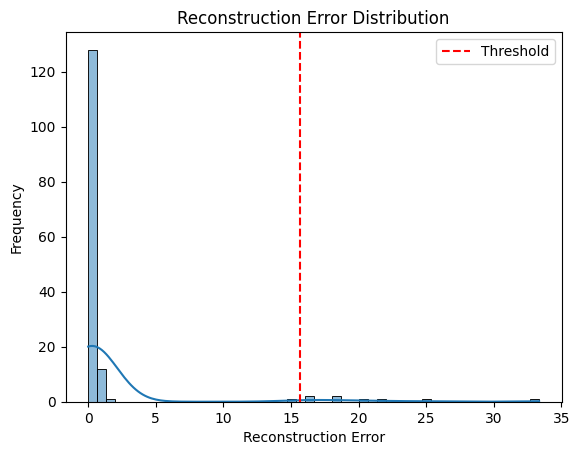

Number of detected intrusions: 8


In [ ]:
#Plotting the distribution of reconstruction error
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Print number of detected intrusions
print(f"Number of detected intrusions: {np.sum(intrusions)}")